In [27]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

sys.path.append(os.path.abspath(os.path.join('../src')))
from varying_drift_diffusion import *
from motion_simulation import *

# bayesflow
# sys.path.append(os.path.abspath(os.path.join('../../BayesFlow')))
sys.path.append(os.path.abspath(os.path.join('../../../BayesFlow')))
from bayesflow.networks import InvariantNetwork, InvertibleNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.diagnostics import *

from tensorflow.keras.layers import Dense, GRU, LSTM, Conv1D, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential

In [28]:
%load_ext autoreload
%autoreload 2
np.set_printoptions(suppress=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Constants

In [29]:
# simulation
N_SIM = 1000
N_OBS = 100

# bayesflow
PARAM_NAMES = ["a", "ndt", "bias", "kappa"]
N_PARAMS = len(PARAM_NAMES)
N_EPOCHS = 30
ITER_PER_EPOCH = 1000
BATCH_SIZE = 32
N_SAMPLES = 2000

## Simulator Test

In [30]:
n_obs = 100

a     = 1.0
ndt   = 0.2
bias  = 0.5
kappa = 0.1
theta = np.array([a, ndt, bias, kappa])

motion_profiles, condition = motion_experiment(n_obs, n_unique_motions=5, motion_dur=2)
rt, resp = var_dm_simulator(theta, n_obs, motion_profiles)


In [31]:
%time
p_, x_ = var_dm_batch_simulator(32, 100)
x_.shape

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.58 µs


(32, 100, 12)

## Bayes Flow

In [32]:
# default summary network
summary_net = InvariantNetwork()

In [33]:
# invertable inference network
meta_dict={
    'n_coupling_layers': 5,
    's_args': {
        'units': [128, 128],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [128, 128],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'alpha': 1.9,
    'permute': True,
    'use_act_norm': True,
    'n_params': N_PARAMS
}

inference_net = InvertibleNetwork(meta_dict)

In [34]:
# Connect summary and inference network
amortizer = SingleModelAmortizer(inference_net, summary_net)

# Learning-rate decay
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    0.0005, 1000, 0.99, staircase=True
)

trainer = ParameterEstimationTrainer(
    network=amortizer, 
    generative_model=var_dm_batch_simulator,
    learning_rate=learning_rate,
    checkpoint_path='../src/checkpoints/time_var_dm',
    clip_value=3,
    max_to_keep=5
)

Initializing networks from scratch.


In [42]:
%%time
# online training
losses = trainer.train_online(N_EPOCHS, ITER_PER_EPOCH, BATCH_SIZE, n_obs=N_OBS)

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 20h 20min 19s, sys: 18min 52s, total: 20h 39min 12s
Wall time: 1h 18min 18s


## Parameter Recovery

In [43]:
# Simulate and amortized inference
p_, x_ = var_dm_batch_simulator(n_sim=N_SIM,n_obs=N_OBS)
samples = amortizer.sample(x_, n_samples=N_SAMPLES)
param_means = samples.mean(axis=1)

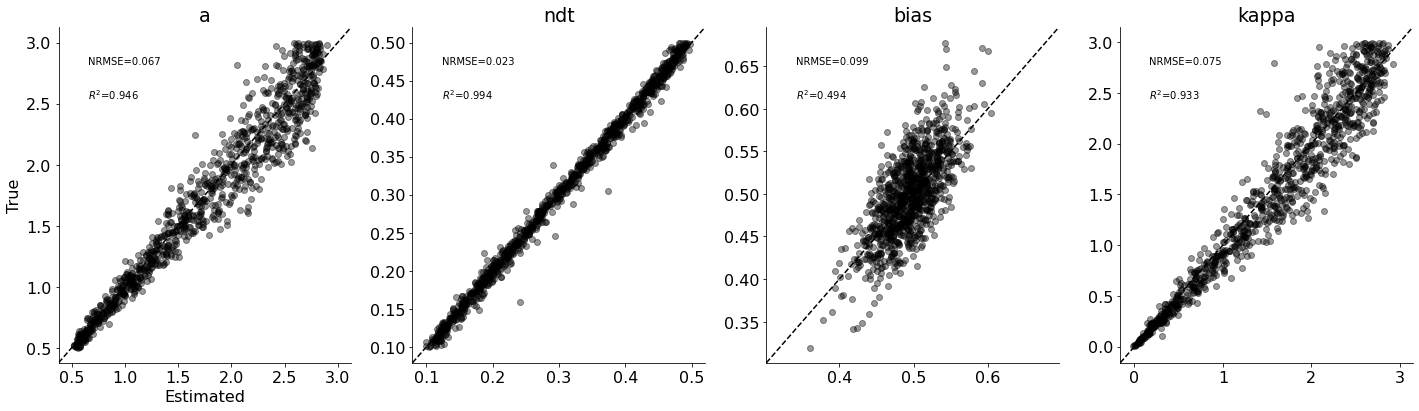

In [50]:
# Recovery plot
true_vs_estimated(theta_true=p_, theta_est=param_means,
                  param_names=PARAM_NAMES, dpi=300, figsize=(20,6),font_size=16)

## Simulation Based Calibration

In [46]:
# Simulate
n_sbc = 5000
n_post_samples_sbc = 250
params, sim_data = var_dm_batch_simulator(n_sbc, N_OBS)

In [47]:
# Amortized inference
param_samples = np.concatenate([amortizer.sample(x, n_post_samples_sbc)
                                for x in tf.split(sim_data, 10, axis=0)], axis=0)

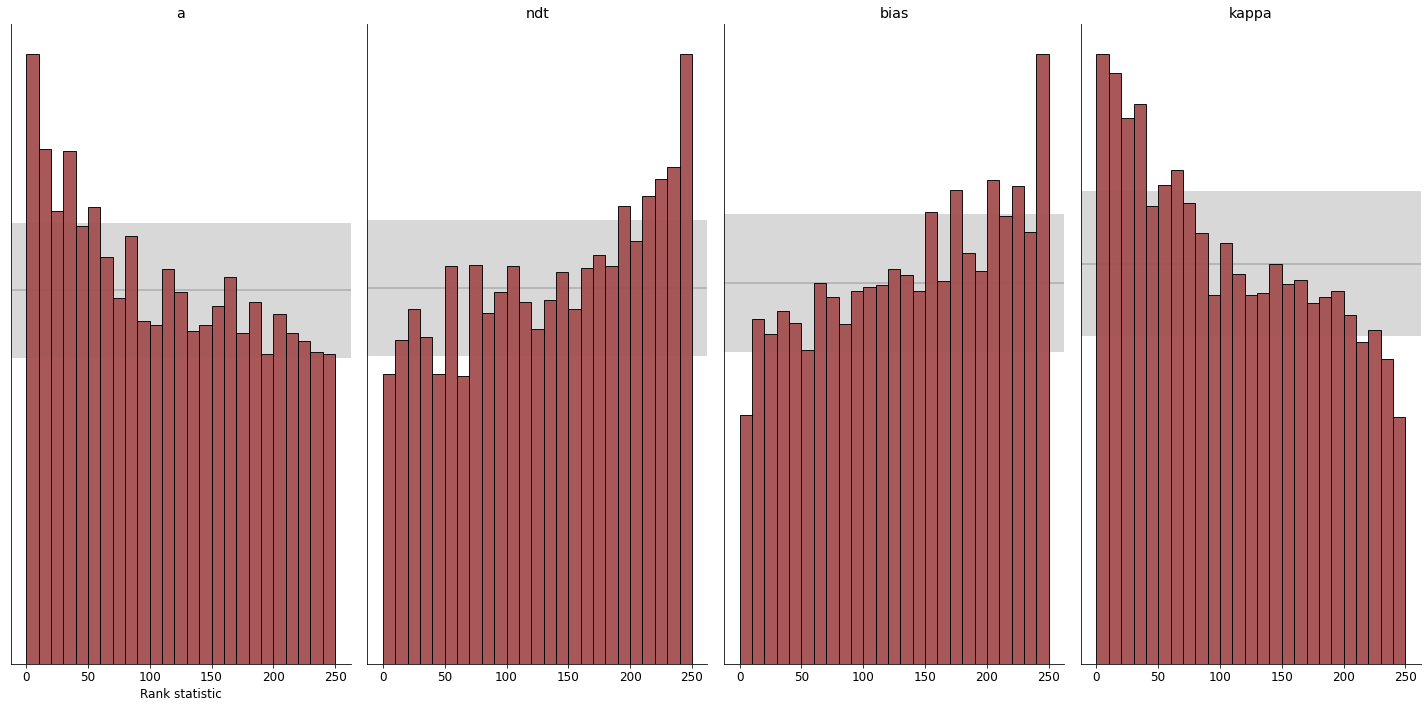

In [48]:
# Rank-plot
f = plot_sbc(param_samples, params, param_names=PARAM_NAMES, figsize=(20, 10))